# PROJECT2_WET

Please make sure your solution is divided into multiple code cells, explained clearly and properly, and most importantly, pretty.


In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import os,time
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("my_project_2").getOrCreate()

## Read Sub Demographic data

In [ ]:
demographic_df = spark.read.parquet("dbfs:/FileStore/project_b_data/proj_B_demographic/")
demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: long (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: double (nullable = true)
 |-- net_worth: double (nullable = true)
 |-- gender_individual: string (nullable = true)
 |-- education_highest: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,gender_individual,education_highest
85,2,1,2,B,W,S,O,15,0.125,0.05,F,1
2073,1,1,2,M,H,S,O,15,0.15,0.1,F,1
2523,7,6,3,M,W,S,O,15,0.1,0.1,M,2
2717,3,2,2,S,W,S,O,11,0.125,0.2,M,3
3364,2,2,2,M,W,S,O,15,0.1,0.1,M,1
4046,4,3,3,M,W,S,O,6,0.075,0.05,F,1
4303,1,1,1,S,W,S,O,15,0.15,0.2,M,1
4559,3,2,2,S,W,S,O,12,0.175,0.2,F,2
5277,3,2,2,M,W,S,R,15,0.125,0.02,M,2
5440,1,1,1,S,W,S,O,8,0.225,0.2,F,1


## Read Static Viewing Data

In [ ]:
schema = StructType([
    StructField("device_id", StringType(), True),
    StructField("event_date", StringType(), True),
    StructField("event_time", StringType(), True),
    StructField("station_num", IntegerType(), True),
    StructField("prog_code", StringType(), True),
    StructField("household_id", IntegerType(), True)
])

viewing_static_df = spark.read.schema(schema).option("header", True).csv("dbfs:/FileStore/project_b_data/viewing_static_csv/")

viewing_static_df.printSchema()
display(viewing_static_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- station_num: integer (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: integer (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
001bd74cc8d1,20150120,181338,75523,EP000009110053,3783713
10ea5940d694,20150120,181338,11218,MV001054110000,3787015
44e08ed80c35,20150120,181338,11713,SH004464010000,43921
0000048de4f2,20150120,181338,65626,MV000506130000,3672067
0000059867a7,20150120,181338,58812,EP019199930005,3645541
000011ff9ba9,20150120,181338,18510,EP010855880111,3642303
00000254e5f6,20150120,181338,35513,EP000369550087,3825751
000002bd8a47,20150120,181338,10035,EP013413450102,2971023
000003c4c597,20150120,181338,59337,MV000744670000,2358722
00407bba00fe,20150120,181338,14771,EP015899250028,2838674


## Static Data Analysis (65 points)

### Feature Extraction

In [ ]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

# First we will scale all numerical columns : "household_size", "num_adults", "num_generations", "length_residence", "home_market_value", "net_worth"
assembler = VectorAssembler(inputCols=["household_size", "num_adults", "num_generations", "length_residence", "home_market_value", "net_worth"], outputCol="features")

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(assembler.transform(demographic_df))
scaled_demo_df = scaler_model.transform(assembler.transform(demographic_df))

🏃 View run bald-bear-707 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/1194242296652548/runs/68b3396a05104a37b5eb5a9ef8c493db
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/1194242296652548


In [ ]:
# Now we will one-hot encode the categorical columns : "marital_status", "race_code", "dwelling_type", "home_owner_status", "gender_individual", "education_highest"

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

# Indexing the data using StringIndexer (while handeling invalid values)
indexer = StringIndexer(inputCols=[
    "marital_status", "race_code", "dwelling_type", "home_owner_status",       "gender_individual", "education_highest"], outputCols=["marital_status_index", "race_code_index", "dwelling_type_index", "home_owner_status_index", "gender_individual_index", "education_highest_index"])
indexer_model = indexer.fit(scaled_demo_df)
indexed_demo_df = indexer_model.transform(scaled_demo_df)

# Encoding the indexed data using one-hot encoding
encoder = OneHotEncoder(inputCols=[
    "marital_status_index", "race_code_index", "dwelling_type_index", "home_owner_status_index", "gender_individual_index", "education_highest_index"], outputCols=["marital_status_vec", "race_code_vec", "dwelling_type_vec", "home_owner_status_vec", "gender_individual_vec", "education_highest_vec"])
encoder_model = encoder.fit(indexed_demo_df)
encoded_demo_df = encoder_model.transform(indexed_demo_df)

🏃 View run painted-shrike-486 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/1194242296652548/runs/638fd2a2f9b14bbd9436511049f1b76d
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/1194242296652548
🏃 View run puzzled-turtle-485 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/1194242296652548/runs/befe2b0c9f95484a9d41d220bd3cb5ee
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/1194242296652548


In [ ]:
# Combaining processed data vectors into one features vector:
cat_vec_cols = [
    "marital_status_vec", "race_code_vec", "dwelling_type_vec",
    "home_owner_status_vec", "gender_individual_vec", "education_highest_vec"]

cat_assembler = VectorAssembler(
    inputCols=cat_vec_cols,
    outputCol="categorical_features")
df_cat = cat_assembler.transform(encoded_demo_df)

# combining numerical and categorical features
df_cat = df_cat.drop("features")
final_assembler = VectorAssembler(
    inputCols=["scaled_features", "categorical_features"],
    outputCol="features")
final_df = final_assembler.transform(df_cat)

# Dropping columns that are no longer needed
cols_to_drop = (
    cat_vec_cols +
    ["categorical_features", "scaled_features"] +
    ["marital_status_index", "race_code_index", "dwelling_type_index",
     "home_owner_status_index", "gender_individual_index", "education_highest_index"])
final_df = final_df.drop(*cols_to_drop)

# Displaying changes:
final_df.select("household_id", "features").show(7, truncate=False)

+------------+---------------------------------------------------------------------------------------------------------+
|household_id|features                                                                                                 |
+------------+---------------------------------------------------------------------------------------------------------+
|85          |(18,[0,2,3,4,5,9,12,13,15],[0.125,0.5,1.0,0.12412412412412413,0.05,1.0,1.0,1.0,1.0])                     |
|2073        |(18,[2,3,4,5,6,11,12,13,15],[0.5,1.0,0.14914914914914915,0.1,1.0,1.0,1.0,1.0,1.0])                       |
|2523        |[0.75,1.0,1.0,1.0,0.09909909909909911,0.1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0]               |
|2717        |[0.25,0.2,0.5,0.7333333333333333,0.12412412412412413,0.2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0]|
|3364        |[0.125,0.2,0.5,1.0,0.09909909909909911,0.1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0]              |
|4046        |[0.375,0.4,1.0,0.4

### Visual Analysis

🏃 View run thundering-shoat-172 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/1194242296652548/runs/bce3e82d17124747981c830146f718f9
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/1194242296652548
+------------+---------------------+---------------------+
|household_id|principal_component_1|principal_component_2|
+------------+---------------------+---------------------+
|85          |0.7696161667682886   |-0.14328450444325833 |
|2073        |1.0470607429479768   |-0.8077002155153569  |
|2523        |-0.21564461720437456 |-1.6496380625532243  |
|2717        |-0.14727133330514722 |-0.009878108533883004|
|3364        |1.0866265581511172   |-1.0202633541472832  |
|4046        |0.9640643076197336   |-0.9501483206226198  |
|4303        |0.6852258565823546   |0.3318621809840822   |
+------------+---------------------+---------------------+
only showing top 7 rows



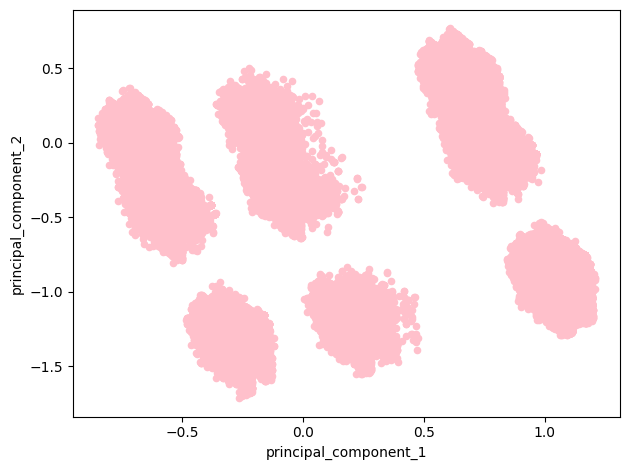

In [ ]:
from pyspark.ml.feature import PCA as pca
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt

# Using PySpark MLlib PCA to reduce the dimensionality of the data
pca = pca(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(final_df)
pca_df = pca_model.transform(final_df)

# Splitting the "pca_features" into seperate columns
pca_df = pca_df.withColumn("pca_array", vector_to_array("pca_features")). \
            withColumn("principal_component_1", col("pca_array")[0]). \
            withColumn("principal_component_2", col("pca_array")[1])

# Showing first 7 data rows
pca_df.select(
    "household_id", "principal_component_1", "principal_component_2")\
        .show(7, truncate=False)

# Scatter plot of the data
temp = pca_df.toPandas()
temp.plot.scatter(
    x='principal_component_1', y='principal_component_2', color='pink')
plt.tight_layout()
plt.show()

### Clustering

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array
from pyspark.ml.linalg import Vectors

# Using PySpark MLlib KMeans to cluster the data
kmeans = KMeans(
    k=6, seed=3, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(pca_df)
clusters = kmeans_model.transform(pca_df)

# Cluster's dataframe
cluster_center_df = spark.createDataFrame(
    [(i, Vectors.dense(c)) for i, c in enumerate(kmeans_model.clusterCenters())],["cluster", "center"])

# Attaching cluster centers to the clusters dataframe
clusters = clusters.join(cluster_center_df, on="cluster", how="left")

features_col = kmeans.getFeaturesCol()

# Calculating the euclidean distance between each point and its cluster center
eucli_dist = F.zip_with(
    vector_to_array(F.col(features_col)),
    vector_to_array(F.col("center")),
    lambda x, y: (x - y) * (x - y))
dist2 = F.aggregate(eucli_dist, F.lit(0.0), lambda acc, v: acc + v)
clusters = clusters.withColumn("distance_to_center", F.sqrt(dist2))

clusters.select(
    "household_id", "cluster", F.round("distance_to_center", 5)\
        .alias("dist")).show(7, truncate=False)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run gifted-fawn-594 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/1194242296652548/runs/cda54646290e4ffab0d5f6f2da413528
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/1194242296652548
+------------+-------+-------+
|household_id|cluster|dist   |
+------------+-------+-------+
|85          |1      |0.95686|
|2073        |2      |0.84815|
|2523        |0      |1.32964|
|2717        |1      |1.43151|
|3364        |5      |0.58616|
|4046        |5      |0.93581|
|4303        |1      |0.97057|
+------------+-------+-------+
only showing top 7 rows



### Dividing households into subsets

In [ ]:
from pyspark.sql.window import Window

# Defining the window
wind = Window.partitionBy("cluster")\
    .orderBy(F.col("distance_to_center").asc())

# Ranking the data based on the distance to the cluster center
ranked_clusters = clusters.withColumn("rank", F.row_number().over(wind))
ranks_full = ranked_clusters.select("household_id", "cluster")

# Extracting every 3rd data point from each cluster
ranks_3rd = ranked_clusters.filter((F.col("rank") % 3) == 0).\
    select("household_id", "cluster")
ranks_3rd.select("cluster").distinct().orderBy("cluster").show()

# Extracting every 17th data point from each cluster
ranks_17th = ranked_clusters.filter((F.col("rank") % 17) == 0).\
    select("household_id", "cluster")

+-------+
|cluster|
+-------+
|      0|
|      1|
|      2|
|      3|
|      4|
|      5|
+-------+



### Cluster’s Viewing Analysis

In [ ]:
# Step 1:
# First we will join the subset DF with the viewing_static_df
ranks_full_with_views = ranks_full.join(viewing_static_df, on="household_id", how="inner").\
    groupBy("cluster" , "station_num").\
    agg(F.count("*").alias("num_views"))
ranks_3rd_with_views = ranks_3rd.join(viewing_static_df, on="household_id", how="inner").\
    groupBy("cluster" , "station_num").\
    agg(F.count("*").alias("num_views"))
ranks_17th_with_views = ranks_17th.join(viewing_static_df, on="household_id", how="inner").\
    groupBy("cluster" , "station_num").\
    agg(F.count("*").alias("num_views"))

# Step 2:
# Calculating the "popularity rating" of each station in each cluster
# First we will define a window
windi = Window.partitionBy("cluster")
# Then we will calculate the popularity rating of each station in each cluster
ranks_full_with_popularity_rating = ranks_full_with_views.\
    withColumn("popularity_rating", (F.col("num_views") / F.sum("num_views").over(windi)) * 100)
ranks_3rd_with_popularity_rating = ranks_3rd_with_views.\
    withColumn("popularity_rating", (F.col("num_views") / F.sum("num_views").over(windi)) * 100)
ranks_17th_with_popularity_rating = ranks_17th_with_views.\
    withColumn("popularity_rating", (F.col("num_views") / F.sum("num_views").over(windi)) * 100)

# Step 3:
# Repeating steps 1,2 on the viewing_static_df , without joining with the demographic_df
total_global = viewing_static_df.count()
viewing_static_df_with_popularity_rating = (
    viewing_static_df
    .groupBy("station_num")
    .agg(F.count("*").alias("num_views"))
    .withColumn("general_popularity_rating",
                F.col("num_views") / F.lit(total_global) * 100)
    .select("station_num", "general_popularity_rating"))

# Step 4:
# Calculating "diff_rank" between the "popularity_rating" of each station in each cluster and the "popularity_rating" of each station in the entire dataset
ranks_full_with_diff_rank = ranks_full_with_popularity_rating.\
    join(viewing_static_df_with_popularity_rating, on="station_num", how="inner").\
    withColumn("diff_rank", F.col("popularity_rating") - F.col("general_popularity_rating")).\
    withColumn("abs_diff_rank", F.abs(F.col("diff_rank")))
ranks_3rd_with_diff_rank = ranks_3rd_with_popularity_rating.\
    join(viewing_static_df_with_popularity_rating, on="station_num", how="inner").\
    withColumn("diff_rank", F.col("popularity_rating") - F.col("general_popularity_rating")).\
    withColumn("abs_diff_rank", F.abs(F.col("diff_rank")))
ranks_17th_with_diff_rank = ranks_17th_with_popularity_rating.\
    join(viewing_static_df_with_popularity_rating, on="station_num", how="inner").\
    withColumn("diff_rank", F.col("popularity_rating") - F.col("general_popularity_rating")).\
    withColumn("abs_diff_rank", F.abs(F.col("diff_rank")))

# Defining a window to help extract the top 7 stations with the highest diff_rank for each cluster and subset
windo = Window.partitionBy("cluster").orderBy(
    F.col("diff_rank").desc(),
    F.col("station_num"))
full_top_7 = ranks_full_with_diff_rank.\
    withColumn("rank_by_diff", F.row_number().over(windo)).\
    filter(F.col("rank_by_diff") <= 7).\
    withColumn("subset", F.lit("Full")).\
    withColumn("subset_title",
        F.concat(F.lit("Cluster "),
        F.col("cluster"),
        F.lit(" — Full Subset"))).\
    select("subset_title","subset","cluster","station_num",
            F.col("popularity_rating").alias("popularity_cluster"),
            "general_popularity_rating","diff_rank","abs_diff_rank","rank_by_diff")
subset_3rd_top_7 = ranks_3rd_with_diff_rank.\
    withColumn("rank_by_diff", F.row_number().over(windo)).\
    filter(F.col("rank_by_diff") <= 7).\
    withColumn("subset", F.lit("3rd")).\
    withColumn("subset_title",
        F.concat(F.lit("Cluster "),
        F.col("cluster"),
        F.lit(" — 3rd Subset"))).\
    select("subset_title","subset","cluster","station_num",
            F.col("popularity_rating").alias("popularity_cluster"),
            "general_popularity_rating","diff_rank","abs_diff_rank","rank_by_diff")
subset_17th_top_7 = ranks_17th_with_diff_rank.\
    withColumn("rank_by_diff", F.row_number().over(windo)).\
    filter(F.col("rank_by_diff") <= 7).\
    withColumn("subset", F.lit("17th")).\
    withColumn("subset_title",
        F.concat(F.lit("Cluster "),
        F.col("cluster"),
        F.lit(" — 17th Subset"))).\
    select("subset_title","subset","cluster","station_num",
            F.col("popularity_rating").alias("popularity_cluster"),
            "general_popularity_rating","diff_rank","abs_diff_rank","rank_by_diff")

In [ ]:
from IPython.display import HTML, display
import pandas as pd, re

# Displaying the top 7 stations with the highest diff_rank for each cluster and subset
results_for_display = full_top_7.unionByName(subset_3rd_top_7).unionByName(subset_17th_top_7) \
    .orderBy("cluster",
             F.when(F.col("subset")=="Full", 0)
              .when(F.col("subset")=="3rd", 1)
              .otherwise(2),
             "rank_by_diff")
# Here we used the help of our dear friend Chat GPT to help us with the HTML display of the table
pdf = (results_for_display
       .select("cluster","subset","rank_by_diff","station_num","diff_rank")
       .orderBy("cluster",
                F.when(F.col("subset")=="Full", 0)
                 .when(F.col("subset")=="3rd", 1)
                 .otherwise(2),
                "rank_by_diff")
       .toPandas())

subset_titles = {"Full":"Full", "3rd":"3rds", "17th":"17ths"}

def table_html(df: pd.DataFrame, caption: str) -> str:
    d = df[["station_num","diff_rank"]].copy()
    d["diff_rank"] = d["diff_rank"].round(4)
    h = d.to_html(index=False, border=0, classes="mini", justify="center", escape=False)
    h = re.sub(r'(<table[^>]*>)', r'\1<caption>{}</caption>'.format(caption), h, count=1)
    return h

def cluster_block(cid: int) -> str:
    g = pdf[pdf["cluster"] == cid]
    cols = []
    for key in ["Full","3rd","17th"]:
        sub = g[g["subset"] == key].sort_values("rank_by_diff")
        cols.append(table_html(sub, subset_titles[key]))
    return f"""
    <section class='cluster'>
      <h2>Cluster {cid}</h2>
      <div class='grid'>
        {cols[0]}
        {cols[1]}
        {cols[2]}
      </div>
    </section>
    """
style = """
<style>
.report { margin:0 auto; }
.cluster { margin: 4px 0 10px; }
.cluster h2 {
  text-align:center; margin: 2px 0 4px;
  font: 600 14px/1.1 system-ui, -apple-system, Segoe UI, Roboto, sans-serif;
}
.grid {
  display:grid; grid-template-columns: repeat(3, minmax(0,1fr));
  gap: 6px; align-items:start;
}
table.mini {
  width:100%; table-layout:fixed; border-collapse:collapse;
  font: 500 10px/1.25 system-ui, -apple-system, Segoe UI, Roboto, sans-serif;
}
table.mini caption {
  caption-side:top; text-align:center; font-weight:600;
  font-size:11px; margin: 0 0 2px;
}
table.mini th, table.mini td {
  padding: 1px 4px; border-bottom: 1px solid #e6e6e6;
  white-space:nowrap; overflow:hidden; text-overflow:ellipsis;
}
table.mini th { text-align:left; }
table.mini td:nth-child(2) { text-align:right; } /* diff_rank לימין */
</style>
"""

html = ["<div class='report'>", style]
for c in sorted(pdf["cluster"].unique()):
    html.append(cluster_block(c))
html.append("</div>")
display(HTML("".join(html)))

station_num,diff_rank
60179,0.3920
16374,0.2273
49788,0.2046
32645,0.1002
10335,0.0875
50747,0.0806
61854,0.0757
station_num,diff_rank
60179,0.2767
32645,0.2471


## Dynamic Data Analysis - Streaming (35 points)

In [ ]:
SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id STRING"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
topic = "view_data"
OFFSETS_PER_TRIGGER = 50000

streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER)\
                  .load()\
                  .select(from_csv(decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")


########## QUERY EXAMPLE ##########

station_counts = streaming_df.groupBy("station_num").count()

count_viewings_per_station_query = station_counts.writeStream\
            .queryName('num_viewing')\
            .format("memory")\
            .outputMode("complete")\
            .start()

time.sleep(10)

for i in range(10):
    print("Batch number: "+str(i))
    print(count_viewings_per_station_query.status)
    spark.sql('SELECT * FROM num_viewing ORDER BY count DESC LIMIT 10').show()
    time.sleep(5)

count_viewings_per_station_query.stop()

Batch number: 0
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+-----------+-----+
|station_num|count|
+-----------+-----+
+-----------+-----+

Batch number: 1
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+-----------+-----+
|station_num|count|
+-----------+-----+
+-----------+-----+

Batch number: 2
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+-----------+-----+
|station_num|count|
+-----------+-----+
+-----------+-----+

Batch number: 3
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+-----------+-----+
|station_num|count|
+-----------+-----+
|      32645| 1288|
|      11221|  795|
|      10179|  783|
|      11187|  763|
|      11713|  757|
|      10171|  590|
|      14771|  584|
|      10035|  578|
|      11150|  549|
|      49788|  545|
+-----------+-----+

Batch number: 4
{'message': 'Processing new data', 'isDataAvailable': Tr

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import decode, from_csv, col, broadcast
from pyspark.sql.window import Window
import time

# Step 1: from the static part of the project we will take the ranks_3rd DataFrame and broadcast it to the streaming part of the project.
thirds_broad = broadcast(ranks_3rd.select("household_id", "cluster"))

# Step 2: here we have two streams, both in complete mode. The first one is a global count of events per station, and the second one is a count of events per station per subset.
total_global_stream = streaming_df.groupBy("station_num").\
    count().withColumnRenamed("count", "global_count").\
    writeStream.format("memory").queryName("global_counts").\
    outputMode("complete").start()

subset_3rd_stream = streaming_df.\
    join(thirds_broad, on="household_id", how="inner").\
    groupBy("cluster", "station_num").count().\
    withColumnRenamed("count", "subset_count").\
    writeStream.format("memory").\
    queryName("subset_counts").outputMode("complete").start()

# Help function to compute the top7 once the streams have data
def compute_top7_once():
    if "global_counts" not in [t.name for t in spark.catalog.listTables()]:
        return None
    if "subset_counts" not in [t.name for t in spark.catalog.listTables()]:
        return None

    global_counts = spark.table("global_counts")
    subset_counts = spark.table("subset_counts")

    if global_counts.count() == 0 or subset_counts.count() == 0:
        return None

    total_global = global_counts.agg(F.sum("global_count").alias("s")).collect()[0]["s"]
    general_pop = global_counts.\
        withColumn("general_popularity_rating", (col("global_count") / F.lit(total_global)) * 100.0).\
        select("station_num", "general_popularity_rating")

    w_cluster = Window.partitionBy("cluster")
    cluster_pop = subset_counts.\
        withColumn("popularity_rating",
                   (col("subset_count")/F.sum("subset_count").over(w_cluster)) * 100.0)

    diff_df = cluster_pop.join(general_pop, on="station_num", how="inner").\
        withColumn("diff_rank", col("popularity_rating") - col("general_popularity_rating")).\
        withColumn("abs_diff_rank", F.abs(col("diff_rank")))

    w_top = Window.partitionBy("cluster").orderBy(F.col("diff_rank").desc(), F.col("station_num"))
    top7 = diff_df.withColumn("rank_by_diff", F.row_number().over(w_top)).\
        filter(col("rank_by_diff") <= 7).withColumn("subset", F.lit("3rd")).\
        withColumn("subset_title",
            F.concat(F.lit("Cluster "), col("cluster"), F.lit(" — 3rd Subset"))).\
        select("subset_title", "subset", "cluster", "station_num",
            F.col("popularity_rating").alias("popularity_cluster"),
            "general_popularity_rating", "diff_rank", "abs_diff_rank", "rank_by_diff")

    top7.createOrReplaceTempView("top7_3rd_current_batch")
    return top7

# Step 3: procesing the data that came from 3 waves of data
def _tables_ready():
    return (spark.catalog.tableExists("global_counts") and
            spark.catalog.tableExists("subset_counts") and
            spark.table("global_counts").count() > 0 and
            spark.table("subset_counts").count() > 0)

# wait until first batch with data actually lands
while not _tables_ready():
    time.sleep(1)
print("first batch processed")

def _totals():
    g = spark.table("global_counts").agg(F.sum("global_count")).first()[0] or 0
    s = spark.table("subset_counts").agg(F.sum("subset_count")).first()[0] or 0
    return g, s

prev_g, prev_s = _totals()

for wave in range(1, 4):
    # wait for a NEW batch (totals increased)
    deadline = time.time() + 120  # safety timeout
    while True:
        g, s = _totals()
        if (g > prev_g) or (s > prev_s):
            prev_g, prev_s = g, s
            break
        if time.time() > deadline:
            print(f"timeout waiting for new data before wave {wave}")
            break
        time.sleep(1)
    print(f"\n--- Wave #{wave} ---")

    top7_df = compute_top7_once()
    if top7_df is None:
        print("we don't have enought data yet in this wave")
    else:
        top7_df.orderBy("cluster", "rank_by_diff").select("cluster", "station_num", "diff_rank").show(42, truncate=False)

# Step 4: stop the streams
subset_3rd_stream.stop()
total_global_stream.stop()

# On this section we used the help of Chat GPT in order to transform our static code into streaming code.

first batch processed

--- Wave #1 ---
+-------+-----------+-------------------+
|cluster|station_num|diff_rank          |
+-------+-----------+-------------------+
|0      |11150      |0.645111655616412  |
|0      |32645      |0.5605018737388296 |
|0      |14321      |0.38684308638416454|
|0      |49788      |0.37804372057269164|
|0      |14771      |0.3430437205726915 |
|0      |56905      |0.2522827904295186 |
|0      |58988      |0.2366808878639377 |
|1      |14902      |0.30997203218450164|
|1      |18480      |0.2636093541585989 |
|1      |10145      |0.24498158426917938|
|1      |14771      |0.2364066950647563 |
|1      |10642      |0.21721289961705603|
|1      |70522      |0.20537223011058042|
|1      |16409      |0.2014691278344306 |
|2      |32645      |1.8788483639265765 |
|2      |10918      |1.3414950784783188 |
|2      |59684      |1.2803532854482578 |
|2      |10222      |1.113460228784251  |
|2      |14321      |1.0904527799946795 |
|2      |10989      |0.88760202181431